# **Analysis of KMeans Clusters**

Name: Kellianne Yang

# Task

For this task, you will analyze the clusters you made in KMeans Exercise Part 1. 

Your stakeholder is a credit card company that wants to market new credit cards. They have asked you to segment their potential customers to determine how and what kind of cards they should market to each group.

You can download the data here: https://assets.codingdojo.com/boomyeah2015/codingdojo/curriculum/content/chapter/cust_seg.csv

The original data is from this data source: https://github.com/Nikhil-Adithyan/Customer-Segmentation-with-K-Means

1. Make a copy of your code file from KMeans Exercise Part 1.
2. Create analytical visualizations that explore statistics for each feature for each cluster.
3. Write a description of each cluster, based on the visualizations you created. Do more than describe the numbers, try to see past the numbers and describe what kinds of people are represented by each cluster. Include at least one insight for each cluster.
4. Create one or two recommendations for your stakeholders (the credit card company) regarding how they should market credit cards differently, or which cards they should market, to each cluster based on your data and insights.
5. Submit your notebook below.


# Preliminary Steps

In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer

In [2]:
!pip install kneed
from kneed import KneeLocator

In [3]:
# load data
path = 'Data/cust_seg.csv'
df = pd.read_csv(path, index_col = 0)

In [4]:
# inspect
df.info()
df.sample(10)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 850 entries, 0 to 849
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Customer Id      850 non-null    int64  
 1   Age              850 non-null    int64  
 2   Edu              850 non-null    int64  
 3   Years Employed   850 non-null    int64  
 4   Income           850 non-null    int64  
 5   Card Debt        850 non-null    float64
 6   Other Debt       850 non-null    float64
 7   Defaulted        700 non-null    float64
 8   DebtIncomeRatio  850 non-null    float64
dtypes: float64(4), int64(5)
memory usage: 66.4 KB


,Customer Id,Age,Edu,Years Employed,Income,Card Debt,Other Debt,Defaulted,DebtIncomeRatio
2,3,33,2,10,57,6.111,5.802,1.0,20.9
746,747,44,2,17,129,0.551,2.674,0.0,2.5
428,429,35,3,7,38,1.383,4.355,0.0,15.1
647,648,29,2,0,22,1.039,1.799,1.0,12.9
408,409,31,4,7,97,1.827,3.993,NaN,6.0
795,796,38,3,3,25,0.312,0.613,0.0,3.7
804,805,30,1,12,38,0.171,3.059,0.0,8.5
666,667,36,1,14,81,1.785,4.047,0.0,7.2
139,140,40,2,5,35,1.584,4.156,1.0,16.4
542,543,27,3,4,40,0.284,0.956,1.0,3.1


In [5]:
# delete column(s) that should not factor into clusters
df.drop(columns = 'Customer Id', inplace = True)

# check
df.columns

Index(['Age', 'Edu', 'Years Employed', 'Income', 'Card Debt', 'Other Debt',
       'Defaulted', 'DebtIncomeRatio'],
      dtype='object')

In [6]:
# check for impossible numeric values
df.describe()

,Age,Edu,Years Employed,Income,Card Debt,Other Debt,Defaulted,DebtIncomeRatio
count,850.000000,850.000000,850.000000,850.000000,850.000000,850.000000,700.000000,850.000000
mean,35.029412,1.710588,8.565882,46.675294,1.576820,3.078773,0.261429,10.171647
std,8.041432,0.927784,6.777884,38.543054,2.125843,3.398799,0.439727,6.719441
min,20.000000,1.000000,0.000000,13.000000,0.012000,0.046000,0.000000,0.100000
25%,29.000000,1.000000,3.000000,24.000000,0.382500,1.045750,0.000000,5.100000
50%,34.000000,1.000000,7.000000,35.000000,0.885000,2.003000,0.000000,8.700000
75%,41.000000,2.000000,13.000000,55.750000,1.898500,3.903250,1.000000,13.800000
max,56.000000,5.000000,33.000000,446.000000,20.561000,35.197000,1.000000,41.300000


In [7]:
# check for duplicates
df.duplicated().sum()

0

In [8]:
# check for missing values
df.isna().sum()

Age                  0
Edu                  0
Years Employed       0
Income               0
Card Debt            0
Other Debt           0
Defaulted          150
DebtIncomeRatio      0
dtype: int64

In [9]:
# fill missing values in 'Defaulted' column
df['Defaulted'].value_counts()

0.0    517
1.0    183
Name: Defaulted, dtype: int64

In [10]:
# most people have not defaulted, so I will fill the missing values with 0
df.fillna(value = df['Defaulted'].mode()[0], inplace = True)

# check
df.isna().sum()

Age                0
Edu                0
Years Employed     0
Income             0
Card Debt          0
Other Debt         0
Defaulted          0
DebtIncomeRatio    0
dtype: int64

In [11]:
# fit and transform data with scaler
scaled_data = StandardScaler().fit_transform(df)

# check
scaled_data[:5]

array([[ 0.74291541,  0.31212243, -0.37878978, -0.71845859, -0.68381116,
        -0.59048916, -0.52379654, -0.57652509],
       [ 1.48949049, -0.76634938,  2.5737211 ,  1.38432469,  1.41447366,
         1.51296181, -0.52379654,  0.39138677],
       [-0.25251804,  0.31212243,  0.2117124 ,  0.26803233,  2.13414111,
         0.80170393,  1.90913822,  1.59755385],
       [-0.75023477,  0.31212243, -0.67404087, -0.71845859, -0.42164323,
        -0.75446707, -0.52379654, -0.57652509],
       [ 1.48949049, -0.76634938,  3.31184882,  5.35624866,  3.63890032,
         1.71609424, -0.52379654, -0.44250653]])

# Inertia plot to find number of clusters

C:\Users\yang0108\AppData\Local\anaconda3\envs\dojo-env\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\yang0108\AppData\Local\anaconda3\envs\dojo-env\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\yang0108\AppData\Local\anaconda3\envs\dojo-env\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\yang0108\AppData\Local\anaconda3\e

Text(0, 0.5, 'inertia')

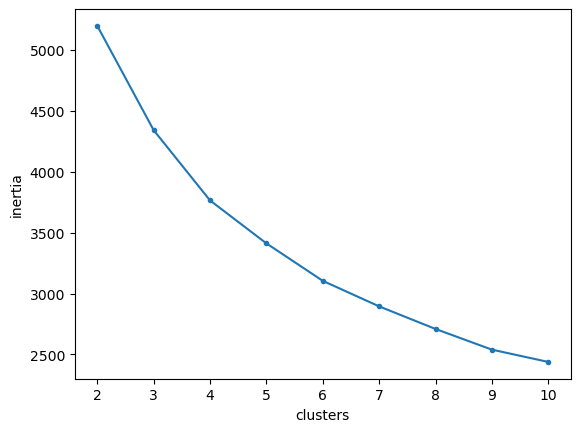

In [12]:
# create list for inertias
inertias = []

# loop through k values 2-10 and store inertias in list
for k in range(2, 11):
  kmeans = KMeans(n_clusters = k, random_state = 42)
  kmeans.fit(scaled_data)
  inertias.append(kmeans.inertia_)

# visualize elbow plot of inertias
plt.plot(range(2,11), inertias, marker = '.')
plt.xlabel('clusters')
plt.ylabel('inertia')

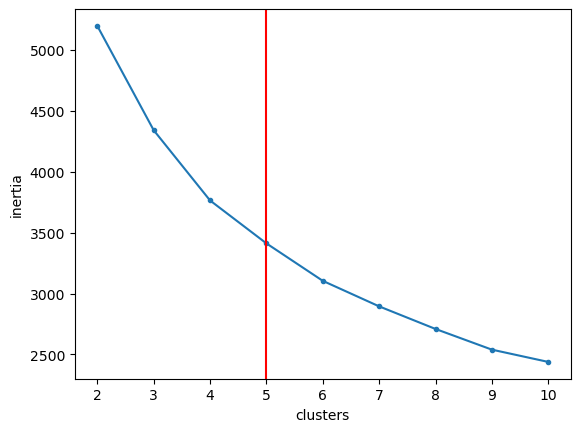

Knee point: 5


In [13]:
# calculate elbow (knee) point for decreasing convex function

# find the knee point using the KneeLocator function
knee_locator = KneeLocator(range(2, 11), 
                           inertias, 
                           curve = 'convex', 
                           direction = 'decreasing',
                           interp_method = 'polynomial')
knee = knee_locator.knee

# plot the data and knee point
plt.plot(range(2, 11), inertias, marker = '.')
plt.axvline(x = knee, color = 'red')
plt.xlabel('clusters')
plt.ylabel('inertia')
plt.xticks(range(2, 11))
plt.show()

print('Knee point:', knee)

The inertia plot indicates that 5 would be a good possible number of clusters for this data.

# Silhouette score plot to find number of clusters

C:\Users\yang0108\AppData\Local\anaconda3\envs\dojo-env\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\yang0108\AppData\Local\anaconda3\envs\dojo-env\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\yang0108\AppData\Local\anaconda3\envs\dojo-env\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\yang0108\AppData\Local\anaconda3\e

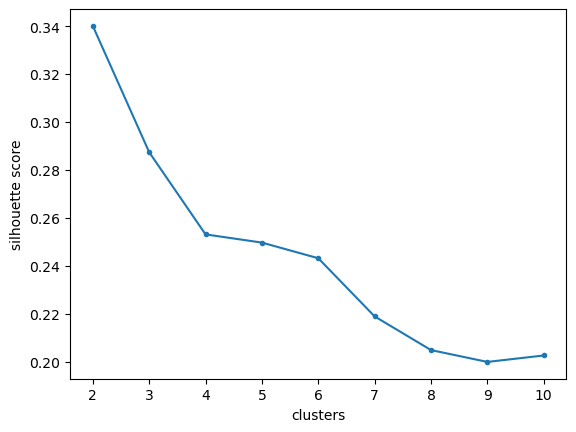

In [14]:
# create list for silhouette scores
silhouette_scores = []

for k in range(2, 11):
  kmeans = KMeans(n_clusters = k, random_state = 42)
  kmeans.fit(scaled_data)
  silhouette_scores.append(silhouette_score(scaled_data, kmeans.labels_))

# visualize silhouette_scores
plt.plot(range(2, 11), 
         silhouette_scores, 
         marker = '.')
plt.xlabel('clusters')
plt.ylabel('silhouette score')
plt.xticks(range(2, 11))
plt.show();

In [15]:
# determine how many clusters produces the highest silhouette score in a table
silhouette_df = pd.DataFrame()

silhouette_df['silhouette_score'] = silhouette_scores
silhouette_df['clusters'] = range(2, 11)

silhouette_df.sort_values(by = 'silhouette_score', ascending = False).head()

,silhouette_score,clusters
0,0.340117,2
1,0.287387,3
2,0.253074,4
3,0.249648,5
4,0.243115,6


The silhouette scores plot indicates that 2 would be a good possible number of clusters for this data.

# K decision

The two plots, an elbow plot and a silhouette score plot, indicate different numbers of clusters to use for this data. The elbow plot indicates 5 clusters, although the elbow plot does not show a very distinct elbow. The silhouette scores indicate that 2 clusters should be used. 

Because the elbow plot does not have a very defined elbow, and the silhouette scores plot clearly indicates that 2 clusters has a much higher silhouette score than the other numbers of clusters, I will choose to continue with 2 clusters. For a more involved analysis, I would look at both 2 and 5 clusters, and maybe a few more similar numbers, as options. 

In [16]:
# make model with 2 clusters
kmeans = KMeans(n_clusters = 2, random_state = 42)
kmeans.fit(scaled_data)

# add clusters as column in df
df['cluster'] = kmeans.labels_

# check
df.head()

C:\Users\yang0108\AppData\Local\anaconda3\envs\dojo-env\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


,Age,Edu,Years Employed,Income,Card Debt,Other Debt,Defaulted,DebtIncomeRatio,cluster
0,41,2,6,19,0.124,1.073,0.0,6.3,0
1,47,1,26,100,4.582,8.218,0.0,12.8,1
2,33,2,10,57,6.111,5.802,1.0,20.9,1
3,29,2,4,19,0.681,0.516,0.0,6.3,0
4,47,1,31,253,9.308,8.908,0.0,7.2,1


# Analytical Visualizations for Each Cluster

Create analytical visualizations that explore statistics for each feature for each cluster.

In [17]:
# look at aggregate means by cluster in table form
# as_index = False makes clusters a column instead of the index
cluster_groups = df.groupby('cluster', as_index = False).mean()
cluster_groups

,cluster,Age,Edu,Years Employed,Income,Card Debt,Other Debt,Defaulted,DebtIncomeRatio
0,0,32.968563,1.645210,6.492515,33.618263,0.937349,1.899054,0.215569,9.126796
1,1,42.593407,1.950549,16.175824,94.598901,3.923890,7.408731,0.214286,14.006593


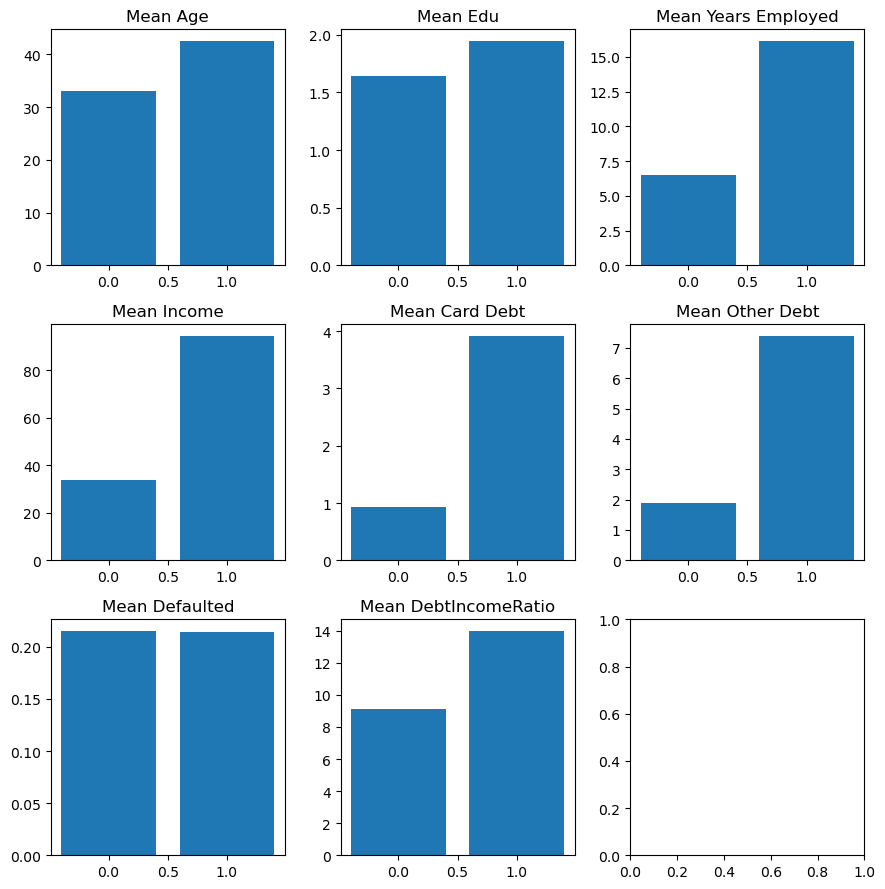

In [18]:
# visualize the clusters' aggregate means with bar charts
# 8 columns
fig, axes = plt.subplots(3, 3, figsize = (9, 9))

# axes.ravel() flattens array
axes = axes.ravel()

# loop over columns and plot each; skip 'cluster' column
for i, col in enumerate(cluster_groups.columns[1:]):
  axes[i].bar(cluster_groups['cluster'], cluster_groups[col])
  axes[i].set_title(f"Mean {col}")

plt.tight_layout()

# Descriptions of Each Cluster

Write a description of each cluster, based on the visualizations you created. Do more than describe the numbers, try to see past the numbers and describe what kinds of people are represented by each cluster. Include at least one insight for each cluster.

## Cluster 0

This cluster is slightly younger (mean age low 30s). They are a little less educated, have been employed for fewer years, and have a lower income, all factors which may relate to their younger age.

They have less card and other debt, and a lower debt to income ratio. They have defaulted at the same rate as cluster 1.

## Cluster 1:

This cluster is older, more educated, has been employed for longer, and has a significantly higher mean income than cluster 0. 

However, they also have much higher card and other debt, and a higher debt to income ratio on average. 

They have defaulted on their debt at about the same rate as cluster 0. 

# Recommendations for Stakeholders

Create one or two recommendations for your stakeholders (the credit card company) regarding how they should market credit cards differently, or which cards they should market, to each cluster based on your data and insights.

## Cluster 0: 

Provide a low-interest, and low-/no-fee credit card option. This cluster makes less money, and also has less debt, and so are probably looking to pay less for a credit card, and pay off what they put on a credit card quickly.

## Cluster 1: 

This cluster is older and earns more money, and accrues more debt. You can provide a higher-interest card option, with a higher limit. They may want a card option with more rewards or points to distinguish from other offers.